In [1]:
import pandas as pd
from pprint import pprint
import stan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pickle
import nest_asyncio
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn import metrics
import pickle
import nest_asyncio
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
import arviz as az
nest_asyncio.apply()

In [2]:
def generate_binary_irt_data(sim_input):
    # simulate abilities, difficulties, and subject/item combinations
    sim_ability = normal(loc=0,
                         scale=sim_input['sigma_ability'],
                         size=sim_input['S'])
    sim_difficulty = normal(loc=sim_input['mu_difficulty'],
                            scale=sim_input['sigma_difficulty'],
                            size=sim_input['I'])
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['N'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['N'])
    # work out success probabilities
    sim_success_probabilities = expit(sim_ability[sim_subject] -
                                      sim_difficulty[sim_item])
    # simulate grades
    sim_grade = binomial(n=1,
                         p=sim_success_probabilities,
                         size=sim_input['N'])
    # Dictionary of data to give to STAN
    sim_data = {
        'grade': sim_grade,
        'subject': sim_subject + 1,
        'item': sim_item + 1,
    }
    sim_data.update({i: binary_sim_input[i] for i in ['N', 'I', 'S']})
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: binary_sim_input[i] for i in ['sigma_ability',
                                                          'mu_difficulty',
                                                          'sigma_difficulty']})
    return sim_data, recoverables

# define some input data
binary_sim_input = {'N': 10000,
                    'I': 15,
                    'S': 15,
                    'sigma_ability': 1,
                    'sigma_difficulty': 2,
                    'mu_difficulty': -1}
binary_sim_data, binary_sim_recoverables = generate_binary_irt_data(binary_sim_input)
# print results
print('Here is our randomly generated data:')
pprint(binary_sim_data)  # pprint makes the dictionary print nicely

Here is our randomly generated data:
{'I': 15,
 'N': 10000,
 'S': 15,
 'grade': array([0, 1, 0, ..., 1, 1, 1]),
 'item': array([ 6, 15,  1, ...,  8, 10,  8]),
 'subject': array([13,  3,  4, ...,  7,  4,  8])}


In [3]:
# From stan documentation
_1pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  real ability[S];             //  alpha: ability od student
  real difficulty[I];          //  beta: difficulty of question
  real delta;                   // man student ability
  
}
model {

  ability ~ std_normal();         
  difficulty ~ std_normal();   
  delta ~ normal(0.75,1);
  
  for(n in 1:N)
      grade[n] ~ bernoulli_logit(ability[subject[n]] - difficulty[item[n]] + delta);
  
}
generated quantities{
  vector[N] log_lik;
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf( grade[n] | ability[subject[n]] - difficulty[item[n]] + delta);
  }
}
"""
## Model from Stan documantation
_2pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  vector[S] ability;             //  alpha ability od student
  vector[I] difficulty;          //  beta difficulty of question
  vector<lower=0>[I] discrimination;      // discrimination of question
  real mu_difficulty;
}
model {
  ability ~ std_normal();         
  difficulty ~ std_normal();   
  discrimination ~ lognormal(0,1);
  mu_difficulty ~ cauchy(0,5);
  
  grade ~ bernoulli_logit(discrimination[item] .* (ability[subject] - (difficulty[item] + mu_difficulty)));
  
}
generated quantities{
  vector[N] log_lik;
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf( grade[n] | discrimination[item[n]] *(ability[subject[n]] - (difficulty[item[n]] + mu_difficulty)));
  }
}
"""
## Model from Stan documantation
multilevel_2pl_model = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> I;  // items,  number of questions  
  int<lower=1> S;  // subjects,  number of users
  
  // data
  
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  
  vector[S] ability;             //  alpha ability od student
  vector[I] difficulty;          //  beta difficulty of question
  vector<lower=0>[I] discrimination;      // discrimination of question
  
  // hyperparameters
  
  real mu_difficulty;                       // mean question difficulty
  real<lower=0> sigma_difficulty;           // scale of difficulty
  real<lower=0> sigma_discrimination;                // scale of log discrimination
}
model {
  ability ~ std_normal();         
  difficulty ~ normal(0,sigma_difficulty);   
  discrimination ~ lognormal(0,sigma_discrimination);
  
  mu_difficulty ~ cauchy(0,5);
  sigma_difficulty ~ cauchy(0,5);
  sigma_discrimination ~ cauchy(0,5);
  
  grade ~ bernoulli_logit(discrimination[item] .* (ability[subject] - (difficulty[item] + mu_difficulty)));
  
}

generated quantities {
  int<lower=0,upper=1> y_pred[N];
  for(n in 1:N)
      y_pred[n] = bernoulli_logit_rng(discrimination[item[n]] * (ability[subject[n]] - (difficulty[item[n]] + mu_difficulty)));
}

"""
# From Exemple
__1pl_model = """
data {
  // numbers of things
  int<lower=1> N;  // responses
  int<lower=1> I;  // items
  int<lower=1> S;  // subjects
  // data
  int<lower=1,upper=I> item[N];
  int<lower=1,upper=S> subject[N];
  int<lower=0,upper=1> grade[N];
}
parameters {
  // parameters
  vector[S] ability;
  vector[I] difficulty;
  // hyperparameters
  real mu_difficulty;
  real<lower=0> sigma_difficulty;
  real<lower=0> sigma_ability;
}
model {
  // priors
  ability ~ normal(0, sigma_ability);
  difficulty ~ normal(0, sigma_difficulty);
  mu_difficulty ~ cauchy(0, 5);
  // data model
  grade ~ bernoulli_logit(ability[subject] - difficulty[item] - mu_difficulty);
}
generated quantities {
  int<lower=0,upper=1> y_pred[N];
  for(n in 1:N)
      y_pred[n] = bernoulli_logit_rng(ability[subject[n]] - difficulty[item[n]] - mu_difficulty);
}
"""

In [4]:
posteriori = stan.build(_1pl_model,data=binary_sim_data,random_seed = 2021)

Building...



Building: found in cache, done.

In [5]:
# fit model
binary_fit = posteriori.sample(num_chains=1, num_samples=2000,num_warmup=1000,num_thin=1)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   3% (100/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  33% (1001/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 0.003564 seconds
  1000 transitions u

In [6]:
binary_fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,ability.1,ability.2,ability.3,...,log_lik.9991,log_lik.9992,log_lik.9993,log_lik.9994,log_lik.9995,log_lik.9996,log_lik.9997,log_lik.9998,log_lik.9999,log_lik.10000
draws,,,,,,,,,,,,,,,,,,,,,
0,-2925.967147,0.952203,0.082733,5.0,47.0,0.0,2942.601559,-1.391995,-0.484778,0.380457,...,-0.010195,-0.598307,-0.017913,-0.880632,-0.519402,-0.004187,-2.006638,-0.026489,-0.056588,-0.014184
1,-2924.300236,1.000000,0.082733,5.0,31.0,0.0,2937.452200,-0.735352,-0.204876,0.429436,...,-0.004758,-0.429717,-0.042127,-0.825843,-0.344586,-0.008417,-2.064788,-0.032702,-0.062932,-0.016527
2,-2917.364254,1.000000,0.082733,5.0,31.0,0.0,2931.577746,-0.986475,-0.307136,0.416370,...,-0.006453,-0.436609,-0.033555,-0.771480,-0.375202,-0.002290,-2.074333,-0.035233,-0.055682,-0.016236
3,-2920.356649,0.935719,0.082733,4.0,31.0,0.0,2932.542762,-1.018310,-0.266143,0.345387,...,-0.004516,-0.542265,-0.041012,-0.766180,-0.389494,-0.005167,-1.916479,-0.046154,-0.045043,-0.026883
4,-2915.785155,0.946817,0.082733,4.0,31.0,0.0,2934.082011,-0.929332,-0.204314,0.583310,...,-0.007909,-0.479900,-0.023068,-0.948802,-0.388742,-0.006072,-2.202109,-0.035081,-0.031941,-0.015787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-2916.675717,0.934748,0.082733,5.0,31.0,0.0,2931.668799,-0.713728,0.058329,0.645550,...,-0.006634,-0.530890,-0.028166,-0.949050,-0.357002,-0.008824,-1.927548,-0.033106,-0.051356,-0.014413
1996,-2921.070491,0.933595,0.082733,5.0,31.0,0.0,2937.223677,-0.620759,0.194131,0.971314,...,-0.006071,-0.485660,-0.031225,-0.855689,-0.404293,-0.002159,-2.221988,-0.023255,-0.061373,-0.013700
1997,-2917.291725,0.999504,0.082733,4.0,15.0,0.0,2929.600998,-0.545168,0.172395,0.867532,...,-0.005370,-0.460410,-0.031799,-0.741972,-0.419608,-0.003267,-1.990788,-0.041202,-0.052048,-0.017927


In [6]:
ability = np.mean(binary_fit['ability'],axis=1)
difficulty = np.mean(binary_fit['difficulty'],axis=1)
#discrimination = np.mean(binary_fit['discrimination'],axis=1)

In [7]:
y_pred = [] #809660
for i in range(0,10000):
    diff = binary_sim_data['item'][i]
    abilt = binary_sim_data['subject'][i]
    p = np.exp(ability[abilt - 1 ] - difficulty[diff - 1])/(1+np.exp(ability[abilt - 1] - difficulty[diff - 1]))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [8]:
print(f" mse = {mean_squared_error(binary_sim_data['grade'],y_pred)} \n kappa = {cohen_kappa_score(binary_sim_data['grade'],y_pred)} \n auc = {roc_auc_score(binary_sim_data['grade'],y_pred)} \n acc = {accuracy_score(binary_sim_data['grade'],y_pred)}   ")

 mse = 0.2687 
 kappa = 0.45427658278272876 
 auc = 0.7835078205807393 
 acc = 0.7313   


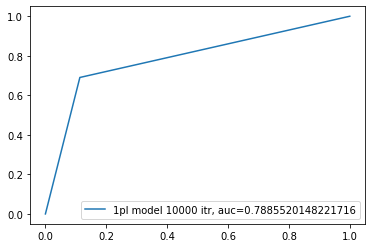

In [21]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(binary_sim_data['grade'],y_pred)
auc = metrics.roc_auc_score(binary_sim_data['grade'],y_pred)
plt.plot(fpr,tpr,label="1pl model 10000 itr, auc="+str(auc))

# pred = np.random.rand(1000)
# label = np.random.randint(2, size=1000)
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
# plt.plot(fpr,tpr,label="data 2, auc="+str(auc))

plt.legend(loc=0)

array([[<AxesSubplot:title={'center':'ability'}>,
        <AxesSubplot:title={'center':'ability'}>],
       [<AxesSubplot:title={'center':'difficulty'}>,
        <AxesSubplot:title={'center':'difficulty'}>],
       [<AxesSubplot:title={'center':'delta'}>,
        <AxesSubplot:title={'center':'delta'}>],
       [<AxesSubplot:title={'center':'log_lik'}>,
        <AxesSubplot:title={'center':'log_lik'}>]], dtype=object)

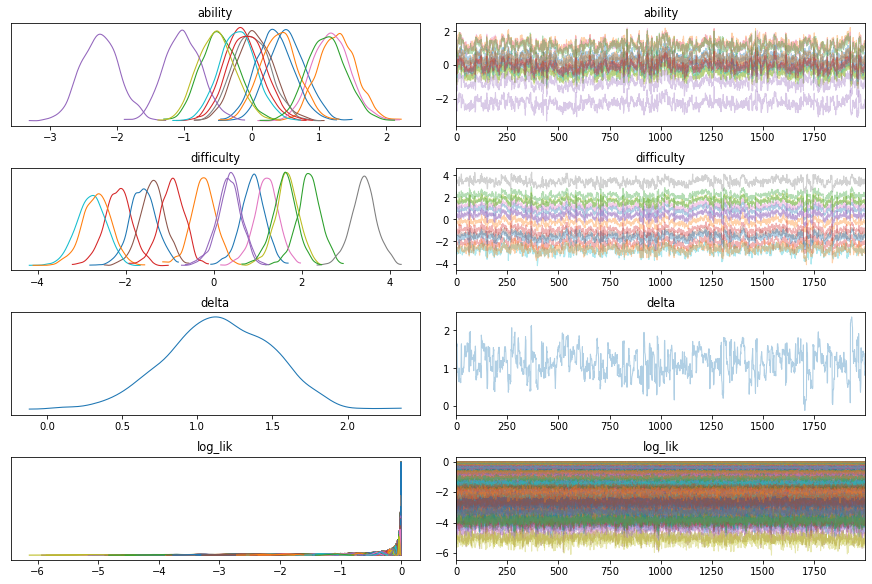

In [15]:
az.plot_trace(binary_fit)

In [22]:
posteriori2 = stan.build(_2pl_model,data=binary_sim_data,random_seed = 2021)

Building...



Building: 59.9s, done.

In [23]:
# fit model
binary_fit2 = posteriori2.sample(num_chains=1, num_samples=2000,num_warmup=500,num_thin=1)

Sampling:   0%
Sampling:   0% (1/2500)
Sampling:   4% (100/2500)
Sampling:   8% (200/2500)
Sampling:  12% (300/2500)
Sampling:  16% (400/2500)
Sampling:  20% (500/2500)
Sampling:  20% (501/2500)
Sampling:  24% (600/2500)
Sampling:  28% (700/2500)
Sampling:  32% (800/2500)
Sampling:  36% (900/2500)
Sampling:  40% (1000/2500)
Sampling:  44% (1100/2500)
Sampling:  48% (1200/2500)
Sampling:  52% (1300/2500)
Sampling:  56% (1400/2500)
Sampling:  60% (1500/2500)
Sampling:  64% (1600/2500)
Sampling:  68% (1700/2500)
Sampling:  72% (1800/2500)
Sampling:  76% (1900/2500)
Sampling:  80% (2000/2500)
Sampling:  84% (2100/2500)
Sampling:  88% (2200/2500)
Sampling:  92% (2300/2500)
Sampling:  96% (2400/2500)
Sampling: 100% (2500/2500)
Sampling: 100% (2500/2500), done.
Messages received during sampling:
  Gradient evaluation took 0.003074 seconds
  1000 transitions using 10 leapfrog steps per transition would take 30.74 seconds.
  Adjust your expectations accordingly!


In [35]:
# print fit summary
print(binary_fit)

<stan.Fit>
Parameters:
    ability: (15,)
    difficulty: (15,)
    delta: ()
    log_lik: (10000,)
Draws: 2000


In [14]:
# Export model
with open("./data/simulated_1pl.pkl", "wb") as f:
    pickle.dump({'model' : posteriori, 'fit' : binary_fit}, f, protocol=-1)
# with open("./data/simulated_2pl.pkl", "wb") as f:
#     pickle.dump({'model' : posteriori2, 'fit' : binary_fit2}, f, protocol=-1)

In [6]:
with open("./data/simulated_1pl.pkl", "rb") as f:
    data_dict = pickle.load(f)
binary_fit = data_dict['fit']
with open("./data/simulated_2pl.pkl", "rb") as f:
    data_dict2 = pickle.load(f)
binary_fit2 = data_dict2['fit']

EOFError: Ran out of input

# Model Selection

In [14]:
import arviz as az

In [25]:
idata = az.from_pystan(binary_fit2, log_likelihood="log_lik")
waic = az.waic(idata)
loo = az.loo(idata)

/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


In [26]:
loo

Computed from 2000 by 10000 log-likelihood matrix

         Estimate       SE
elpd_loo -3787.29    57.61
p_loo       40.96        -

In [27]:
waic

Computed from 2000 by 10000 log-likelihood matrix

          Estimate       SE
elpd_waic -3787.25    57.61
p_waic       40.92        -

There has been a warning during the calculation. Please check the results.

# Exemple

In [18]:
from scipy.stats import bernoulli

In [15]:
ability = np.mean(binary_fit['ability'],axis=1)
difficulty = np.mean(binary_fit['difficulty'],axis=1)
delta = np.mean(binary_fit['delta'],axis=1)
log_lik = np.mean(binary_fit['log_lik'],axis=1)
#discrimination = np.mean(binary_fit2['discrimination'],axis=1)

In [17]:
print(f" {binary_fit['ability'][0][0]} // {binary_fit['difficulty'][0][0]} // {binary_fit['log_lik'][0][0]} // {binary_fit['delta'][0][0]}")

 0.8054239039235521 // -1.4863667700485728 // -0.3486788327785385 // 0.6730738357758974


In [87]:
log_lik.shape

(10000,)

# validation of model

In [76]:
ability = np.mean(binary_fit['ability'],axis=1)
difficulty = np.mean(binary_fit['difficulty'],axis=1)
delta = np.mean(binary_fit['delta'],axis=1)
log_lik = np.mean(binary_fit['log_lik'],axis=1)
#discrimination = np.mean(binary_fit2['discrimination'],axis=1)

array([1.24446353])

In [80]:
y_pred = []
for i in range(0,10000):
    diff = binary_sim_data['item'][i]
    abilt = binary_sim_data['subject'][i]
    p = np.exp(discrimination[diff-1]*(ability[abilt - 1 ] - difficulty[diff - 1]))/(1+np.exp(discrimination[diff-1]*(ability[abilt - 1] - difficulty[diff - 1])))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int)
y_pred

NameError: name 'discrimination' is not defined

In [32]:
x = cohen_kappa_score(binary_sim_data['grade'],y_pred)
x

0.02189742334459177

In [68]:
y_pred = np.mean(binary_fit['y_pred'],axis=1)
y_pred = np.round(y_pred).astype(int)
x = cohen_kappa_score(binary_sim_data['grade'],y_pred)
x

0.5710936906336872

In [ ]:
mse = mean_squared_error(train_data['grade'],y_pred)
mse

In [28]:
y_pred.shape

(10000, 8000)

In [13]:
from scipy.stats import bernoulli

In [57]:
y_pred = []
for i in range(0,10000):
    diff = binary_sim_data['item'][i]
    abilt = binary_sim_data['subject'][i]
    grade = binary_sim_data['grade'][i]
    p = np.exp(ability[abilt - 1 ] - difficulty[diff - 1])/(1+np.exp(ability[abilt - 1] - difficulty[diff - 1]))
    y_pred.append(p)
y_pred = np.round(y_pred).astype(int)
y_pred

array([0, 0, 1, ..., 1, 0, 0])

In [57]:
pystan_function = """
data {
  // numbers of things
  
  int<lower=1> N;  // number of observations
  int<lower=1> X;
  
  // data
  
  real ability[X];
  real difficulty[X];
  real discrimination[X];
  int<lower=0,upper=1> grade[N];
}

generated quantities{
  vector[N] log_lik;
  for (n in 1:N) {
    log_lik[n] = bernoulli_logit_lpmf( grade[n] | ability[n] - difficulty[n] );
  }
}
"""

In [58]:
x = {
    'X':15,
    'N':len(binary_sim_data['grade']),
    'ability' : ability,
    'difficulty': difficulty,
    'discrimination' : discrimination,
    'grade': binary_sim_data['grade']
}

In [62]:
posteriori2 = stan.build(pystan_function,data=x,random_seed = 2021)

Building...



Building: found in cache, done.

In [65]:
fit2 = posteriori2.sample(num_chains=1, num_samples=2000,num_warmup=500,num_thin=1)

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Exception initializing step size.
  Posterior is improper. Please check your model.


AssertionError: 

In [64]:
fit2

NameError: name 'fit2' is not defined

# Model selection

In [10]:
import arviz as az

<AxesSubplot:>

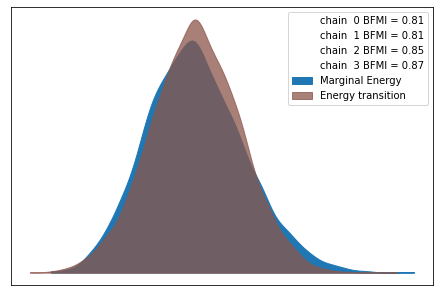

In [11]:
inf_data = az.convert_to_inference_data(binary_fit2)
az.plot_energy(inf_data)

/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/plots/densityplot.py:204: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (46) in plot_density, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'ability\n0'}>,
        <AxesSubplot:title={'center':'ability\n1'}>,
        <AxesSubplot:title={'center':'ability\n2'}>],
       [<AxesSubplot:title={'center':'ability\n3'}>,
        <AxesSubplot:title={'center':'ability\n4'}>,
        <AxesSubplot:title={'center':'ability\n5'}>],
       [<AxesSubplot:title={'center':'ability\n6'}>,
        <AxesSubplot:title={'center':'ability\n7'}>,
        <AxesSubplot:title={'center':'ability\n8'}>],
       [<AxesSubplot:title={'center':'ability\n9'}>,
        <AxesSubplot:title={'center':'ability\n10'}>,
        <AxesSubplot:title={'center':'ability\n11'}>],
       [<AxesSubplot:title={'center':'ability\n12'}>,
        <AxesSubplot:title={'center':'ability\n13'}>,
        <AxesSubplot:title={'center':'ability\n14'}>],
       [<AxesSubplot:title={'center':'difficulty\n0'}>,
        <AxesSubplot:title={'center':'difficulty\n1'}>,
        <AxesSubplot:title={'center':'difficulty\n2'}>],
       [<AxesSubplot:title

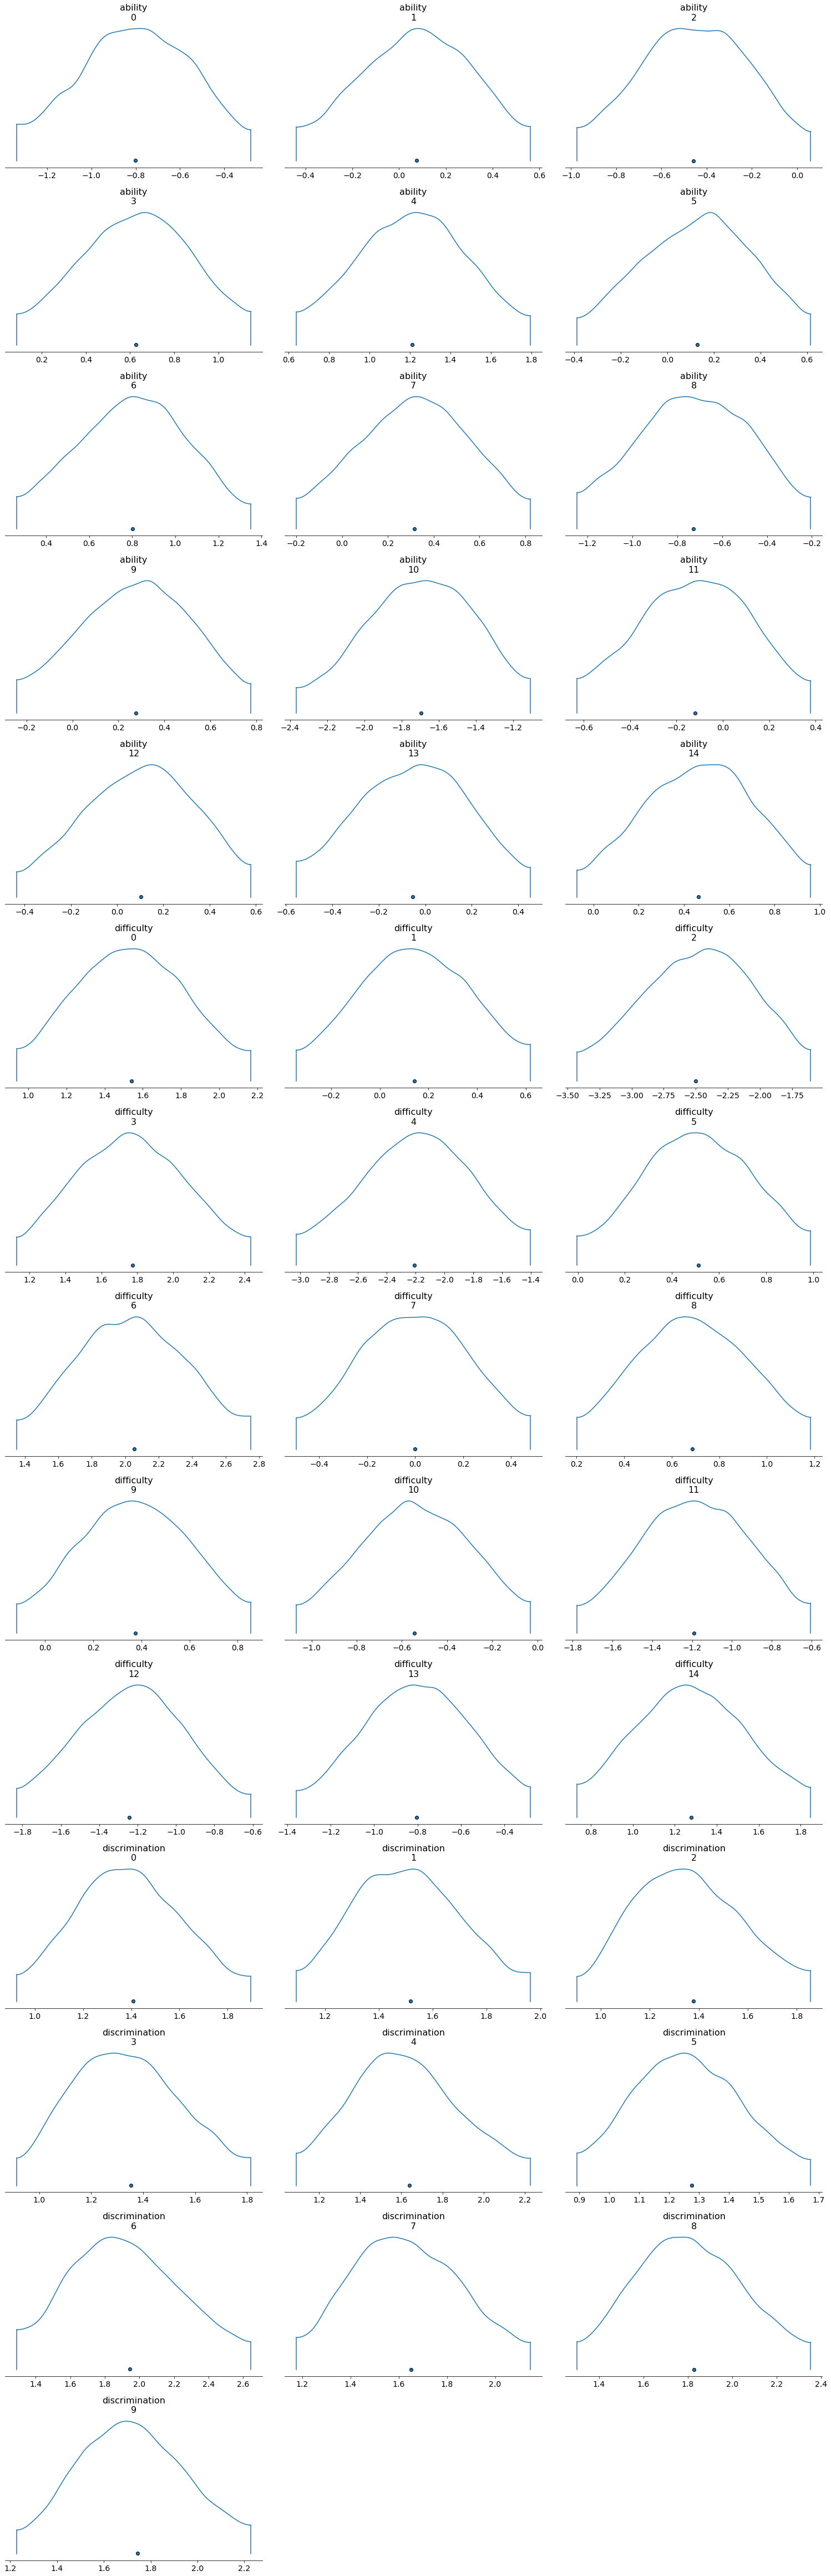

In [12]:
az.plot_density(inf_data)

In [55]:
model1 = binary_fit
model2 = binary_fit
compare_dict = {"model1": model1, "model2": model2}
compare_dict
az.compare(compare_dict)

/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


TypeError: log likelihood not found in inference data object

In [68]:
idata = az.from_pystan(binary_fit2, log_likelihood="log_lik")
waic = az.waic(idata)
loo = az.loo(idata)

/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1405: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/abarchi/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [69]:
loo

Computed from 20 by 10000 log-likelihood matrix

         Estimate       SE
elpd_loo -168450678.87  1776211.04
p_loo    64220738.52        -

There has been a warning during the calculation. Please check the results.

In [70]:
waic

Computed from 20 by 10000 log-likelihood matrix

          Estimate       SE
elpd_waic -69580093348.12  1051495278.72
p_waic    69475863407.78        -

There has been a warning during the calculation. Please check the results.

In [23]:
data1 = az.load_arviz_data("non_centered_eight")
data2 = az.load_arviz_data("centered_eight")
compare_dict = {"non centered": data1, "centered": data2}
az.compare(compare_dict)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
non centered,0,-30.687290,0.841888,0.000000,1.0,1.364996,0.000000,False,log
centered,1,-30.810374,0.954053,0.123084,0.0,1.426837,0.086046,False,log


In [24]:
data1

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> observed_data